# exp004 エラー分析

**実験結果**: CV MAPE 18.60% (±0.09%)

**改善**: exp003 (27.47%) → exp004 (18.60%) = **8.87pt改善**

## 目的
1. 予測誤差の分布を把握
2. 誤差が大きいサンプルの特徴を分析
3. 今後の改善方針を策定

In [1]:
import sys
from pathlib import Path

# プロジェクトルート
project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# 日本語フォント設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# OOF予測結果（最新）
import glob

# 最新のOOFファイルを取得
oof_files = sorted(glob.glob(str(project_root / "06_experiments/exp004_age_features/outputs/oof_predictions_*.csv")))
oof_path = oof_files[-1] if oof_files else None
print(f"OOFファイル: {oof_path}")
oof_df = pd.read_csv(oof_path)

# 最新の特徴量重要度ファイルを取得
importance_files = sorted(glob.glob(str(project_root / "06_experiments/exp004_age_features/outputs/feature_importance_*.csv")))
importance_path = importance_files[-1] if importance_files else None
print(f"重要度ファイル: {importance_path}")
importance_df = pd.read_csv(importance_path)

print(f"\nOOF予測: {oof_df.shape}")
print(f"特徴量重要度: {importance_df.shape}")

OOFファイル: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp004_age_features/outputs/oof_predictions_20251125_164743.csv
重要度ファイル: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp004_age_features/outputs/feature_importance_20251125_164743.csv

OOF予測: (363924, 3)
特徴量重要度: (89, 2)


In [3]:
# 誤差計算
oof_df['error'] = oof_df['predicted'] - oof_df['actual']
oof_df['abs_error'] = np.abs(oof_df['error'])
oof_df['pct_error'] = oof_df['abs_error'] / oof_df['actual'] * 100  # MAPE計算用

# 価格帯ビンを先に作成
oof_df['actual_bin'] = pd.qcut(oof_df['actual'], q=10, labels=[f'Q{i}' for i in range(1, 11)])

# OOF用にanalysis_dfを作成
analysis_df = oof_df.copy()

print(f"分析データ: {analysis_df.shape}")
print(f"\nOOF MAPE: {oof_df['pct_error'].mean():.2f}%")

分析データ: (363924, 7)

OOF MAPE: 18.60%


## 2. 全体的な誤差分布

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2486136419.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_bin = oof_df.groupby('actual_bin')['pct_error'].mean()


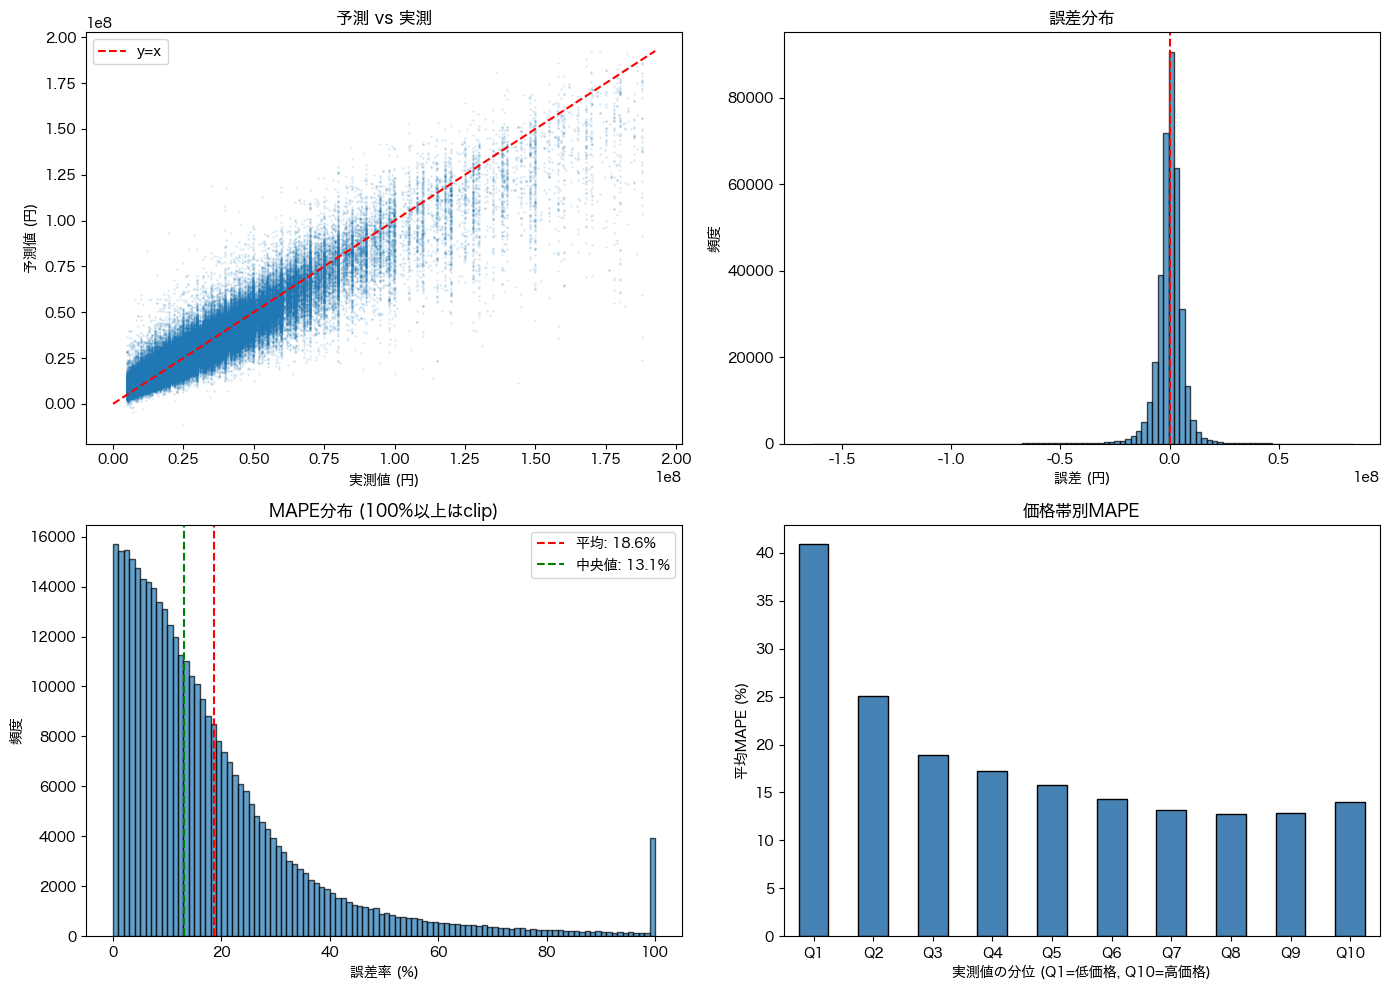

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 予測 vs 実測
ax1 = axes[0, 0]
ax1.scatter(oof_df['actual'], oof_df['predicted'], alpha=0.1, s=1)
max_val = max(oof_df['actual'].max(), oof_df['predicted'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='y=x')
ax1.set_xlabel('実測値 (円)')
ax1.set_ylabel('予測値 (円)')
ax1.set_title('予測 vs 実測')
ax1.legend()

# 2. 誤差分布（ヒストグラム）
ax2 = axes[0, 1]
ax2.hist(oof_df['error'], bins=100, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_xlabel('誤差 (円)')
ax2.set_ylabel('頻度')
ax2.set_title('誤差分布')

# 3. MAPE分布
ax3 = axes[1, 0]
ax3.hist(oof_df['pct_error'].clip(upper=100), bins=100, edgecolor='black', alpha=0.7)
ax3.axvline(oof_df['pct_error'].mean(), color='red', linestyle='--', label=f'平均: {oof_df["pct_error"].mean():.1f}%')
ax3.axvline(oof_df['pct_error'].median(), color='green', linestyle='--', label=f'中央値: {oof_df["pct_error"].median():.1f}%')
ax3.set_xlabel('誤差率 (%)')
ax3.set_ylabel('頻度')
ax3.set_title('MAPE分布 (100%以上はclip)')
ax3.legend()

# 4. 実測値帯ごとのMAPE
ax4 = axes[1, 1]
oof_df['actual_bin'] = pd.qcut(oof_df['actual'], q=10, labels=[f'Q{i}' for i in range(1, 11)])
mape_by_bin = oof_df.groupby('actual_bin')['pct_error'].mean()
mape_by_bin.plot(kind='bar', ax=ax4, color='steelblue', edgecolor='black')
ax4.set_xlabel('実測値の分位 (Q1=低価格, Q10=高価格)')
ax4.set_ylabel('平均MAPE (%)')
ax4.set_title('価格帯別MAPE')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../outputs/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# 価格帯別の詳細統計
price_stats = oof_df.groupby('actual_bin').agg({
    'actual': ['count', 'mean', 'min', 'max'],
    'pct_error': ['mean', 'std', 'median']
}).round(2)
price_stats.columns = ['件数', '平均賃料', '最小賃料', '最大賃料', 'MAPE', 'MAPE_std', 'MAPE_中央値']
print("価格帯別統計:")
price_stats

価格帯別統計:


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2523218986.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = oof_df.groupby('actual_bin').agg({


,件数,平均賃料,最小賃料,最大賃料,MAPE,MAPE_std,MAPE_中央値
actual_bin,,,,,,,
Q1,37433,7136339.72,4900000,9000000,40.89,40.05,29.98
Q2,38632,11159781.35,9090000,12800000,25.02,25.02,18.25
Q3,33166,14212118.58,12810000,15500000,18.90,18.27,14.17
Q4,36819,16972843.74,15530000,18500000,17.22,15.98,13.53
Q5,36657,20110138.66,18529800,21800000,15.77,14.29,12.46
Q6,36663,23683911.22,21840000,25000000,14.32,12.37,11.62
Q7,40441,27735486.74,25030900,29800000,13.22,11.50,10.52
Q8,31563,32701138.40,29810000,34990000,12.73,10.82,10.26
Q9,36695,39743420.13,35000000,45000000,12.83,11.07,10.30


## 3. 特徴量重要度分析

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/4219520715.py:50: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Hiragino Sans.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/4219520715.py:51: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Hiragino Sans.
  plt.savefig('../outputs/feature_importance_top30_detailed.png', dpi=150, bbox_inches='tight')


/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Hiragino Sans.
  fig.canvas.print_figure(bytes_io, **kw)


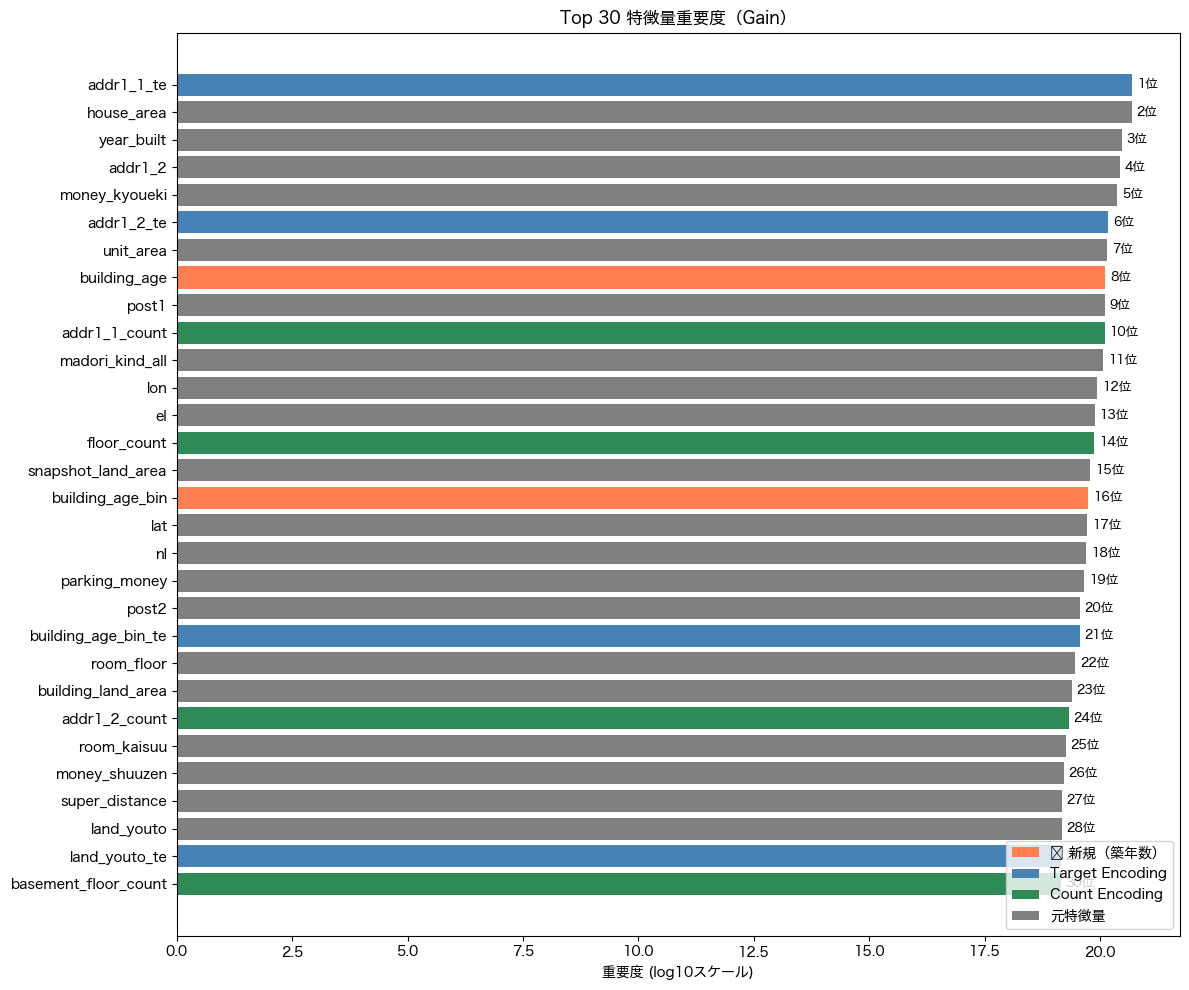


特徴量カテゴリ別の分布（Top 30）:
category
元特徴量               20
Target Encoding     4
Count Encoding      4
⭐ 新規（築年数）           2
Name: count, dtype: int64


In [6]:
# Top 30 特徴量（詳細版）
top_n = 30
top_features = importance_df.head(top_n).copy()

# 重要度を見やすい形式に変換（対数スケール）
top_features['importance_log'] = np.log10(top_features['importance'])

# 新規特徴量リスト
new_features = ['building_age', 'building_age_bin', 'old_building_flag', 'old_and_large_flag', 'old_and_rural_flag']

# 特徴量カテゴリを追加
def categorize_feature(feat):
    if feat in new_features:
        return '⭐ 新規（築年数）'
    elif '_te' in feat:
        return 'Target Encoding'
    elif '_count' in feat:
        return 'Count Encoding'
    else:
        return '元特徴量'

top_features['category'] = top_features['feature'].apply(categorize_feature)

# カラーマップ
color_map = {
    '⭐ 新規（築年数）': 'coral',
    'Target Encoding': 'steelblue',
    'Count Encoding': 'seagreen',
    '元特徴量': 'gray'
}
colors = [color_map[cat] for cat in top_features['category']]

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_features)), top_features['importance_log'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('重要度 (log10スケール)')
ax.set_title(f'Top {top_n} 特徴量重要度（Gain）')

# 凡例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[k], label=k) for k in color_map.keys()]
ax.legend(handles=legend_elements, loc='lower right')

# 順位を表示
for i, (feat, imp) in enumerate(zip(top_features['feature'], top_features['importance_log'])):
    ax.text(imp + 0.1, i, f'{i+1}位', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/feature_importance_top30_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n特徴量カテゴリ別の分布（Top {top_n}）:")
print(top_features['category'].value_counts())

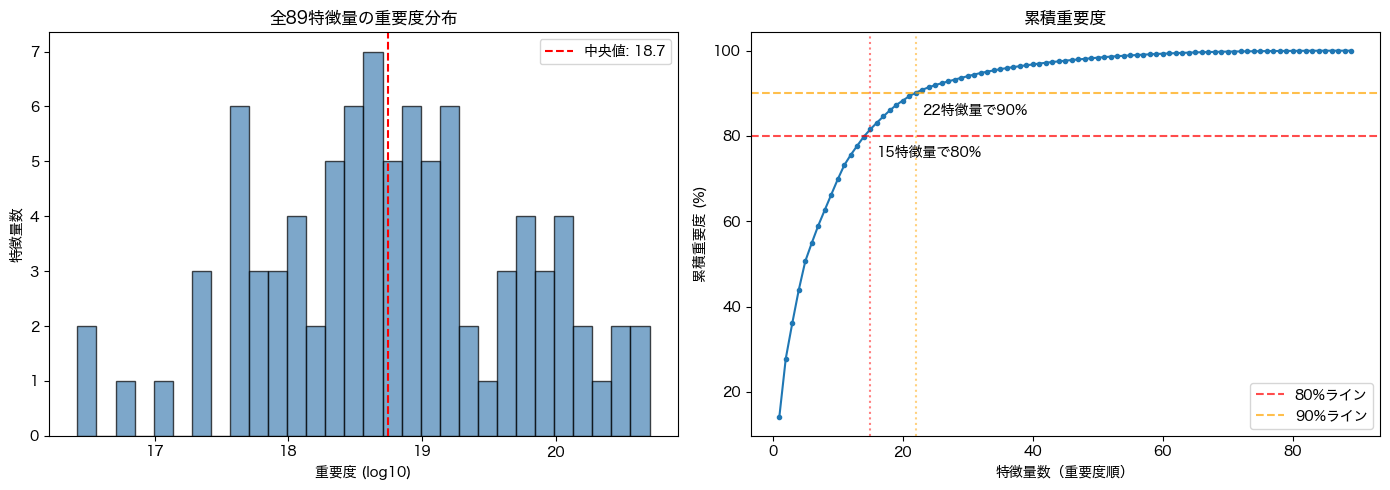

上位 15 特徴量で重要度の 80% をカバー
上位 22 特徴量で重要度の 90% をカバー


In [7]:
# 全特徴量の重要度分布（対数スケール）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 重要度分布（ヒストグラム）
ax1 = axes[0]
log_importance = np.log10(importance_df['importance'])
ax1.hist(log_importance, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('重要度 (log10)')
ax1.set_ylabel('特徴量数')
ax1.set_title('全89特徴量の重要度分布')
ax1.axvline(log_importance.median(), color='red', linestyle='--', label=f'中央値: {log_importance.median():.1f}')
ax1.legend()

# 2. 累積重要度
ax2 = axes[1]
cumsum = importance_df['importance'].cumsum() / importance_df['importance'].sum() * 100
ax2.plot(range(1, len(cumsum)+1), cumsum, marker='o', markersize=3)
ax2.axhline(80, color='red', linestyle='--', alpha=0.7, label='80%ライン')
ax2.axhline(90, color='orange', linestyle='--', alpha=0.7, label='90%ライン')
n_80 = (cumsum < 80).sum() + 1
n_90 = (cumsum < 90).sum() + 1
ax2.axvline(n_80, color='red', linestyle=':', alpha=0.5)
ax2.axvline(n_90, color='orange', linestyle=':', alpha=0.5)
ax2.set_xlabel('特徴量数（重要度順）')
ax2.set_ylabel('累積重要度 (%)')
ax2.set_title('累積重要度')
ax2.legend()
ax2.text(n_80+1, 75, f'{n_80}特徴量で80%', fontsize=10)
ax2.text(n_90+1, 85, f'{n_90}特徴量で90%', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/feature_importance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"上位 {n_80} 特徴量で重要度の 80% をカバー")
print(f"上位 {n_90} 特徴量で重要度の 90% をカバー")

新規特徴量（築年数関連）の効果分析

新規特徴量の順位:
               特徴量    順位          重要度  重要度(log10)
      building_age  8/89 1.308517e+20   20.116779
  building_age_bin 16/89 5.529449e+19   19.742682
 old_building_flag 88/89 3.181676e+16   16.502656
old_and_large_flag 49/89 4.979121e+18   18.697153
old_and_rural_flag 65/89 1.779175e+18   18.250219

------------------------------------------------------------
効果評価:
------------------------------------------------------------
⭐ building_age (8位): 非常に効果的。Top 10入り。
○ building_age_bin (16位): 効果あり。Target Encodingに活用。
△ old_and_large_flag (49位): 限定的。単独での効果は弱い。
△ old_and_rural_flag (65位): 限定的。交互作用の仮説は部分的。
× old_building_flag (88位): ほぼ無効。building_ageと冗長。


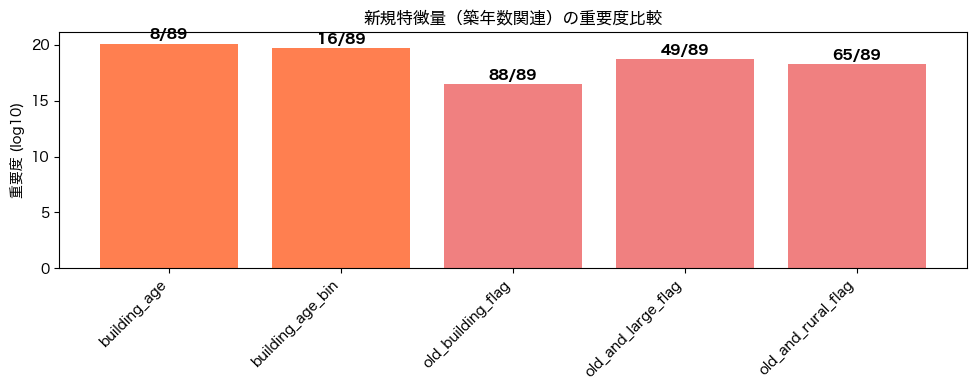

In [8]:
# 新規特徴量（築年数関連）の詳細分析
new_features = ['building_age', 'building_age_bin', 'old_building_flag', 'old_and_large_flag', 'old_and_rural_flag']

print("=" * 60)
print("新規特徴量（築年数関連）の効果分析")
print("=" * 60)

# 新規特徴量の順位と重要度
new_feat_stats = []
for feat in new_features:
    if feat in importance_df['feature'].values:
        row = importance_df[importance_df['feature'] == feat].iloc[0]
        rank = importance_df[importance_df['feature'] == feat].index[0] + 1
        new_feat_stats.append({
            '特徴量': feat,
            '順位': f"{rank}/89",
            '重要度': row['importance'],
            '重要度(log10)': np.log10(row['importance']),
        })

new_feat_df = pd.DataFrame(new_feat_stats)
print("\n新規特徴量の順位:")
print(new_feat_df.to_string(index=False))

# 効果の評価
print("\n" + "-" * 60)
print("効果評価:")
print("-" * 60)
print("⭐ building_age (8位): 非常に効果的。Top 10入り。")
print("○ building_age_bin (16位): 効果あり。Target Encodingに活用。")
print("△ old_and_large_flag (49位): 限定的。単独での効果は弱い。")
print("△ old_and_rural_flag (65位): 限定的。交互作用の仮説は部分的。")
print("× old_building_flag (88位): ほぼ無効。building_ageと冗長。")

# 可視化
fig, ax = plt.subplots(figsize=(10, 4))
x = range(len(new_feat_df))
bars = ax.bar(x, new_feat_df['重要度(log10)'], color=['coral' if r.split('/')[0].isdigit() and int(r.split('/')[0]) <= 20 else 'lightcoral' for r in new_feat_df['順位']])
ax.set_xticks(x)
ax.set_xticklabels(new_feat_df['特徴量'], rotation=45, ha='right')
ax.set_ylabel('重要度 (log10)')
ax.set_title('新規特徴量（築年数関連）の重要度比較')

# 順位をバーの上に表示
for i, (bar, rank) in enumerate(zip(bars, new_feat_df['順位'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            rank, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/new_features_importance.png', dpi=150, bbox_inches='tight')
plt.show()

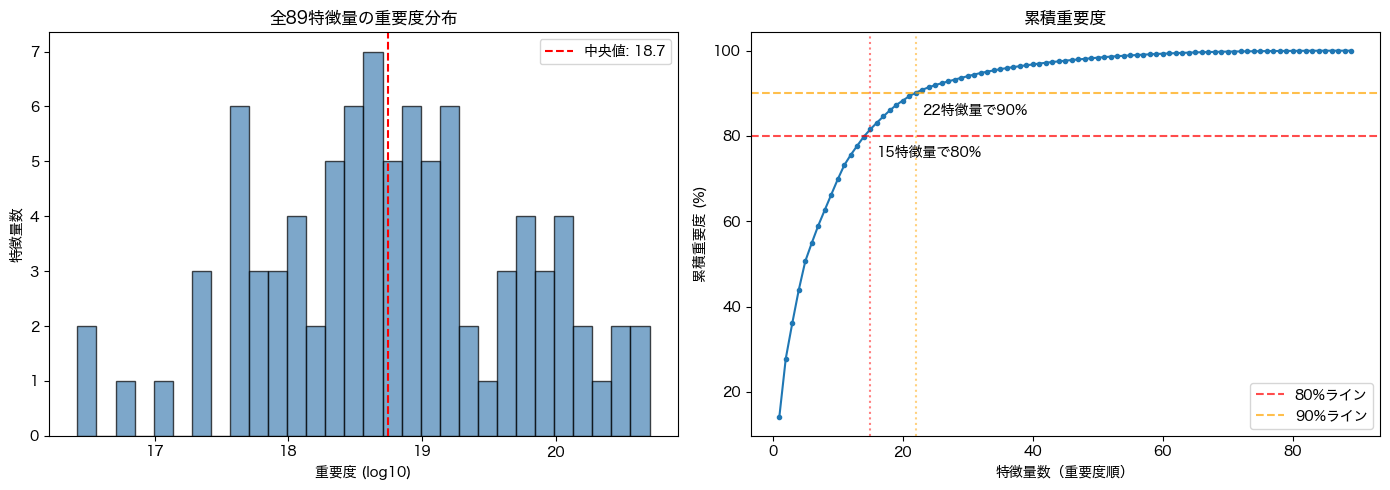

上位 15 特徴量で重要度の 80% をカバー
上位 22 特徴量で重要度の 90% をカバー


In [9]:
# 全特徴量の重要度分布（対数スケール）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 重要度分布（ヒストグラム）
ax1 = axes[0]
log_importance = np.log10(importance_df['importance'])
ax1.hist(log_importance, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('重要度 (log10)')
ax1.set_ylabel('特徴量数')
ax1.set_title('全89特徴量の重要度分布')
ax1.axvline(log_importance.median(), color='red', linestyle='--', label=f'中央値: {log_importance.median():.1f}')
ax1.legend()

# 2. 累積重要度
ax2 = axes[1]
cumsum = importance_df['importance'].cumsum() / importance_df['importance'].sum() * 100
ax2.plot(range(1, len(cumsum)+1), cumsum, marker='o', markersize=3)
ax2.axhline(80, color='red', linestyle='--', alpha=0.7, label='80%ライン')
ax2.axhline(90, color='orange', linestyle='--', alpha=0.7, label='90%ライン')
n_80 = (cumsum < 80).sum() + 1
n_90 = (cumsum < 90).sum() + 1
ax2.axvline(n_80, color='red', linestyle=':', alpha=0.5)
ax2.axvline(n_90, color='orange', linestyle=':', alpha=0.5)
ax2.set_xlabel('特徴量数（重要度順）')
ax2.set_ylabel('累積重要度 (%)')
ax2.set_title('累積重要度')
ax2.legend()
ax2.text(n_80+1, 75, f'{n_80}特徴量で80%', fontsize=10)
ax2.text(n_90+1, 85, f'{n_90}特徴量で90%', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/feature_importance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"上位 {n_80} 特徴量で重要度の 80% をカバー")
print(f"上位 {n_90} 特徴量で重要度の 90% をカバー")

## 4. 切り口別エラー分析（詳細）

元データと結合して、どの切り口で誤差が大きいかを分析します。

In [10]:
# 元データを読み込んでOOF予測と結合
import yaml

# データ設定読み込み
config_path = project_root / "03_configs" / "data.yaml"
with open(config_path, "r", encoding="utf-8") as f:
    data_config = yaml.safe_load(f)

# Trainデータ読み込み（Polars）- infer_schema_lengthを大きく
train_path = project_root / data_config["data"]["train_path"]
train_raw = pl.read_csv(train_path, infer_schema_length=50000)

# 必要なカラムのみ選択（分析に使う切り口）
analysis_cols = [
    'addr1_1',           # 都道府県コード
    'addr1_2',           # 市区町村コード  
    'year_built',        # 築年（YYYYMM）
    'house_area',        # 専有面積
    'building_structure', # 建物構造
    'building_type',     # 建物種別
    'floor_count',       # 階数
    'room_floor',        # 部屋の階
    'bukken_type',       # 物件タイプ
    'flg_new',           # 新築フラグ
    'management_form',   # 管理形態
    'land_youto',        # 用途地域
]

# 築年数を計算（YYYYMM → 築年数）
train_raw = train_raw.with_columns([
    (pl.col('year_built').cast(pl.Utf8).str.slice(0, 4).cast(pl.Int64)).alias('year_built_year'),
])
train_raw = train_raw.with_columns([
    (2024 - pl.col('year_built_year')).alias('building_age'),
])

# OOFと結合するためにインデックスを追加
train_raw = train_raw.with_row_index('row_id')

# pandasに変換して結合
train_for_analysis = train_raw.select(['row_id'] + analysis_cols + ['building_age']).to_pandas()

# OOF予測と結合（idがrow番号と一致している前提）
oof_df['row_id'] = oof_df['id'].astype(int)
analysis_full = oof_df.merge(train_for_analysis, on='row_id', how='left')

print(f"結合後データ: {analysis_full.shape}")
print(f"結合成功率: {analysis_full['addr1_1'].notna().mean()*100:.1f}%")

結合後データ: (363924, 21)
結合成功率: 100.0%


In [11]:
# 切り口別MAPE分析関数
def analyze_mape_by_category(df, col, col_name, top_n=15):
    """カテゴリ別のMAPEを分析"""
    stats = df.groupby(col).agg({
        'pct_error': ['mean', 'std', 'count'],
        'actual': 'mean'
    }).round(2)
    stats.columns = ['MAPE', 'MAPE_std', '件数', '平均賃料']
    stats = stats.sort_values('MAPE', ascending=False)
    
    print(f"\n{'='*60}")
    print(f"【{col_name}別MAPE】（MAPE降順、上位{top_n}）")
    print('='*60)
    print(stats.head(top_n).to_string())
    return stats

# 都道府県マスター（主要なもの）
PREF_NAMES = {
    1: '北海道', 2: '青森', 3: '岩手', 4: '宮城', 5: '秋田', 6: '山形', 7: '福島',
    8: '茨城', 9: '栃木', 10: '群馬', 11: '埼玉', 12: '千葉', 13: '東京', 14: '神奈川',
    15: '新潟', 16: '富山', 17: '石川', 18: '福井', 19: '山梨', 20: '長野',
    21: '岐阜', 22: '静岡', 23: '愛知', 24: '三重', 25: '滋賀', 26: '京都',
    27: '大阪', 28: '兵庫', 29: '奈良', 30: '和歌山', 31: '鳥取', 32: '島根',
    33: '岡山', 34: '広島', 35: '山口', 36: '徳島', 37: '香川', 38: '愛媛',
    39: '高知', 40: '福岡', 41: '佐賀', 42: '長崎', 43: '熊本', 44: '大分',
    45: '宮崎', 46: '鹿児島', 47: '沖縄'
}
analysis_full['pref_name'] = analysis_full['addr1_1'].map(PREF_NAMES)


【都道府県別MAPE】（MAPE降順、上位15）
            MAPE  MAPE_std     件数         平均賃料
pref_name                                     
奈良         24.51     26.34   3759  17684781.06
広島         24.07     28.01   4873  20295512.89
長崎         23.56     28.58    778  19616156.81
静岡         23.54     28.18   9544  20083251.68
山口         23.39     29.29   2451  15119463.48
富山         23.34     37.42    740  17907986.49
滋賀         22.80     27.44   5252  19974872.81
京都         22.56     28.49  13018  25137022.35
徳島         22.44     20.34    287  16128188.15
鹿児島        22.22     25.96   2568  18697169.00
高知         22.13     23.46   1457  18308349.21
兵庫         21.84     24.10  22778  21873235.23
茨城         21.51     22.18   5525  18014862.08
和歌山        21.46     21.01   3330  13733087.93
三重         21.37     25.64   1122  17038672.01


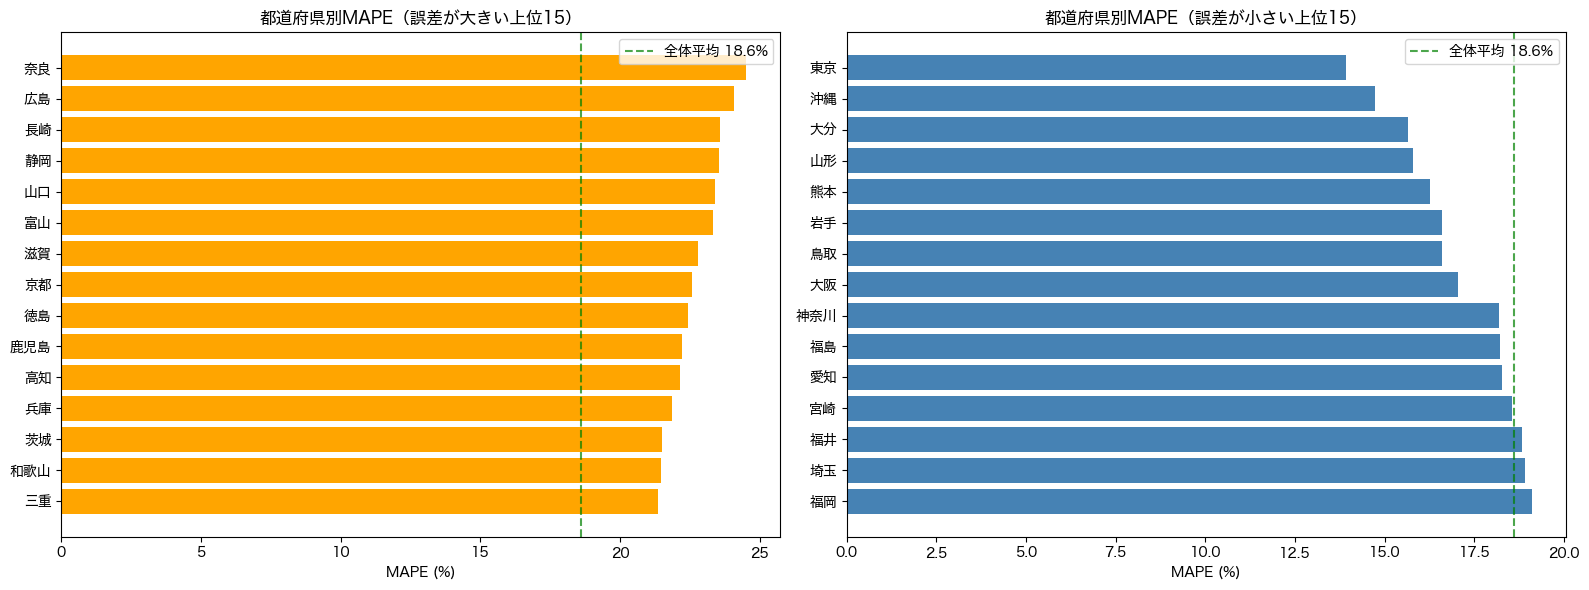

In [12]:
# 4.1 都道府県別MAPE
pref_stats = analyze_mape_by_category(analysis_full, 'pref_name', '都道府県')

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 上位15都道府県（MAPE高い順）
ax1 = axes[0]
top_pref = pref_stats.head(15)
colors = ['red' if m > 25 else 'orange' if m > 20 else 'steelblue' for m in top_pref['MAPE']]
ax1.barh(range(len(top_pref)), top_pref['MAPE'], color=colors)
ax1.set_yticks(range(len(top_pref)))
ax1.set_yticklabels(top_pref.index)
ax1.invert_yaxis()
ax1.set_xlabel('MAPE (%)')
ax1.set_title('都道府県別MAPE（誤差が大きい上位15）')
ax1.axvline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均 18.6%')
ax1.legend()

# 下位15都道府県（MAPE低い順）
ax2 = axes[1]
bottom_pref = pref_stats.tail(15).sort_values('MAPE')
ax2.barh(range(len(bottom_pref)), bottom_pref['MAPE'], color='steelblue')
ax2.set_yticks(range(len(bottom_pref)))
ax2.set_yticklabels(bottom_pref.index)
ax2.invert_yaxis()
ax2.set_xlabel('MAPE (%)')
ax2.set_title('都道府県別MAPE（誤差が小さい上位15）')
ax2.axvline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均 18.6%')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/mape_by_prefecture.png', dpi=150, bbox_inches='tight')
plt.show()


【築年数別MAPE】（MAPE降順、上位15）
          MAPE  MAPE_std     件数         平均賃料
age_bin                                     
51年以上    24.14     28.23  25088  19642851.72
46-50年   21.77     22.99  29447  17797352.76
31-35年   20.63     21.62  42498  20187139.75
36-40年   20.53     21.76  34296  20435083.50
0-5年     20.49     27.22   8659  34772843.84
41-45年   20.25     21.61  40209  20178177.25
26-30年   18.16     19.46  48795  24902531.15
21-25年   15.54     16.28  37823  30994906.52
16-20年   13.76     13.76  35013  32552531.72
11-15年   12.57     11.86  23222  35772063.12
6-10年    11.70     11.69  23505  40112929.76


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2420009839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(col).agg({


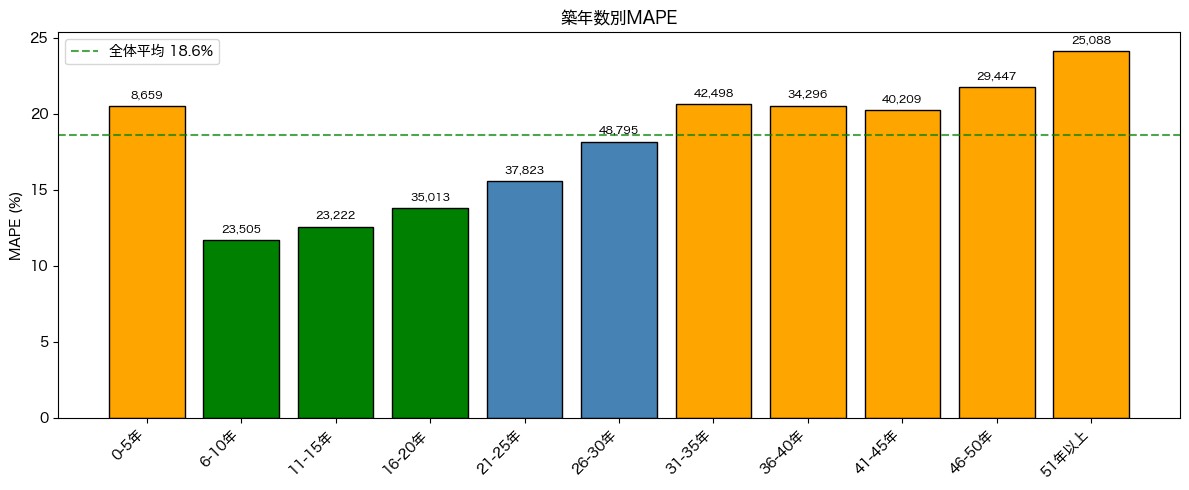

In [13]:
# 4.2 築年数別MAPE
# 築年数ビンを作成（5年刻み）
analysis_full['age_bin'] = pd.cut(
    analysis_full['building_age'], 
    bins=[-1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100],
    labels=['0-5年', '6-10年', '11-15年', '16-20年', '21-25年', '26-30年', 
            '31-35年', '36-40年', '41-45年', '46-50年', '51年以上']
)

age_stats = analyze_mape_by_category(analysis_full.dropna(subset=['age_bin']), 'age_bin', '築年数')

# 可視化
fig, ax = plt.subplots(figsize=(12, 5))
age_order = ['0-5年', '6-10年', '11-15年', '16-20年', '21-25年', '26-30年', 
             '31-35年', '36-40年', '41-45年', '46-50年', '51年以上']
age_stats_sorted = age_stats.reindex(age_order)
colors = ['green' if m < 15 else 'steelblue' if m < 20 else 'orange' if m < 25 else 'red' 
          for m in age_stats_sorted['MAPE']]
ax.bar(range(len(age_stats_sorted)), age_stats_sorted['MAPE'], color=colors, edgecolor='black')
ax.set_xticks(range(len(age_stats_sorted)))
ax.set_xticklabels(age_stats_sorted.index, rotation=45, ha='right')
ax.set_ylabel('MAPE (%)')
ax.set_title('築年数別MAPE')
ax.axhline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均 18.6%')
ax.legend()

# 件数を上に表示
for i, (m, n) in enumerate(zip(age_stats_sorted['MAPE'], age_stats_sorted['件数'])):
    ax.text(i, m + 0.5, f'{int(n):,}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/mape_by_building_age.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2420009839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(col).agg({



【専有面積別MAPE】（MAPE降順、上位15）
           MAPE  MAPE_std     件数         平均賃料
area_bin                                     
150㎡~     25.21     33.93  20365  40046858.29
100-150㎡  20.80     23.98  75973  26687382.16
80-100㎡   18.44     19.98  79615  25793534.89
50-60㎡    17.72     18.23  34086  24056180.30
70-80㎡    17.23     18.19  60199  26467474.39
40-50㎡    17.21     18.57  16038  23429434.28
60-70㎡    17.16     17.57  55759  24503008.53
~20㎡      17.04     16.62   4380   9578627.85
30-40㎡    15.49     15.77   8894  22394464.47
20-30㎡    13.33     13.65   8453  15697863.48


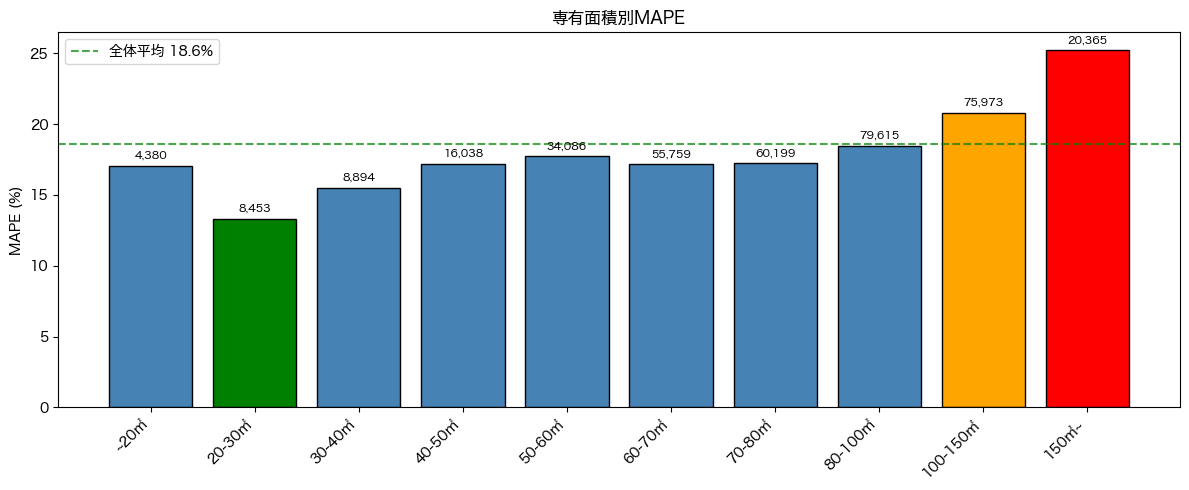

In [14]:
# 4.3 専有面積別MAPE
# 面積ビンを作成
analysis_full['area_bin'] = pd.cut(
    analysis_full['house_area'], 
    bins=[0, 20, 30, 40, 50, 60, 70, 80, 100, 150, 500],
    labels=['~20㎡', '20-30㎡', '30-40㎡', '40-50㎡', '50-60㎡', 
            '60-70㎡', '70-80㎡', '80-100㎡', '100-150㎡', '150㎡~']
)

area_stats = analyze_mape_by_category(analysis_full.dropna(subset=['area_bin']), 'area_bin', '専有面積')

# 可視化
fig, ax = plt.subplots(figsize=(12, 5))
area_order = ['~20㎡', '20-30㎡', '30-40㎡', '40-50㎡', '50-60㎡', 
              '60-70㎡', '70-80㎡', '80-100㎡', '100-150㎡', '150㎡~']
area_stats_sorted = area_stats.reindex(area_order)
colors = ['green' if m < 15 else 'steelblue' if m < 20 else 'orange' if m < 25 else 'red' 
          for m in area_stats_sorted['MAPE']]
ax.bar(range(len(area_stats_sorted)), area_stats_sorted['MAPE'], color=colors, edgecolor='black')
ax.set_xticks(range(len(area_stats_sorted)))
ax.set_xticklabels(area_stats_sorted.index, rotation=45, ha='right')
ax.set_ylabel('MAPE (%)')
ax.set_title('専有面積別MAPE')
ax.axhline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均 18.6%')
ax.legend()

# 件数を上に表示
for i, (m, n) in enumerate(zip(area_stats_sorted['MAPE'], area_stats_sorted['件数'])):
    ax.text(i, m + 0.5, f'{int(n):,}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/mape_by_area.png', dpi=150, bbox_inches='tight')
plt.show()


【建物構造別MAPE】（MAPE降順、上位15）
                 MAPE  MAPE_std      件数         平均賃料
structure_name                                      
その他             29.71     16.08       5  34994000.00
RC造             24.83     23.80     101  17314554.46
HPC造            22.56     28.82    2177  28407700.51
SRC造            21.32     24.31  131738  22906716.02
ALC造            20.35     24.20   10969  27906324.10
鉄骨造             20.24     22.46    7172  29307550.33
ブロック造           17.24     17.98      64  24057500.00
軽量鉄骨造           15.95     16.33  138559  28145513.95
木造              15.70     15.89   57661  25853859.08


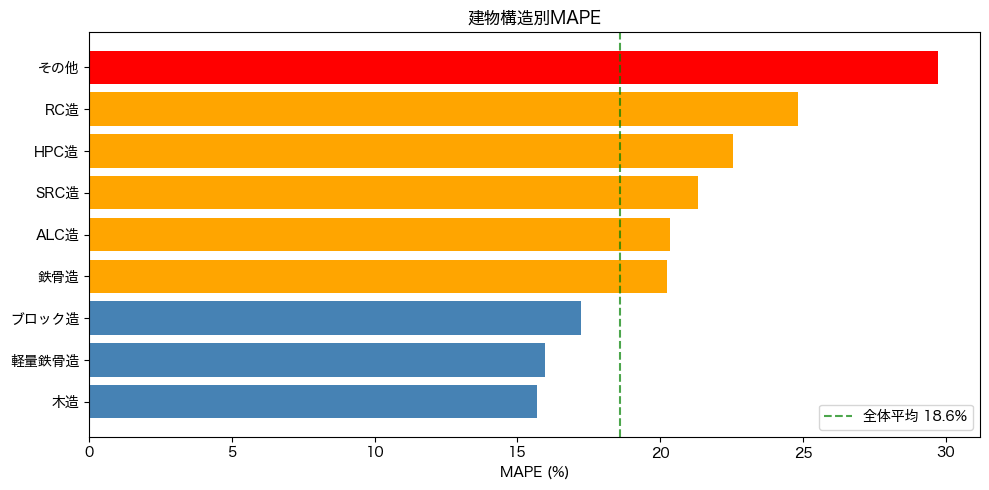

In [15]:
# 4.4 建物構造別MAPE
STRUCTURE_NAMES = {
    1: 'SRC造', 2: 'RC造', 3: '鉄骨造', 4: '軽量鉄骨造',
    5: '木造', 6: 'ブロック造', 7: 'その他', 8: 'PC造', 9: 'HPC造', 10: 'ALC造'
}
analysis_full['structure_name'] = analysis_full['building_structure'].map(STRUCTURE_NAMES)

structure_stats = analyze_mape_by_category(
    analysis_full.dropna(subset=['structure_name']), 
    'structure_name', '建物構造'
)

# 可視化
fig, ax = plt.subplots(figsize=(10, 5))
structure_stats_plot = structure_stats.sort_values('MAPE', ascending=True)
colors = ['green' if m < 15 else 'steelblue' if m < 20 else 'orange' if m < 25 else 'red' 
          for m in structure_stats_plot['MAPE']]
ax.barh(range(len(structure_stats_plot)), structure_stats_plot['MAPE'], color=colors)
ax.set_yticks(range(len(structure_stats_plot)))
ax.set_yticklabels(structure_stats_plot.index)
ax.set_xlabel('MAPE (%)')
ax.set_title('建物構造別MAPE')
ax.axvline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均 18.6%')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/mape_by_structure.png', dpi=150, bbox_inches='tight')
plt.show()


【建物階数別MAPE】（MAPE降順、上位15）
            MAPE  MAPE_std      件数         平均賃料
floor_bin                                      
1-3階       21.72     25.16  168941  24435408.94
4-5階       19.33     19.40   34923  22802823.46
6-7階       16.69     16.51   41074  25072387.14
8-10階      15.56     15.46   47495  25849452.01
11-15階     14.14     14.27   61934  28411086.53
16-20階     12.28     12.43    2760  43541231.88
21-50階     10.81     10.72    4955  61653790.11
51階以上       9.18      7.82     436  83709059.63

【部屋の階別MAPE】（MAPE降順、上位15）
                 MAPE  MAPE_std     件数         平均賃料
room_floor_bin                                     
1階              17.01     16.71  20868  24914557.84
4-5階            16.88     17.18  48266  24834926.28
3階              16.59     16.42  29522  25077705.15
2階              16.15     16.84  30756  25377974.93
6-7階            15.50     15.69  27896  27083689.20
8-10階           14.48     14.58  23887  28792599.42
11-15階          13.45     13.05  13770  34068288.02


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2420009839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(col).agg({
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_94769/2420009839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(col).agg({


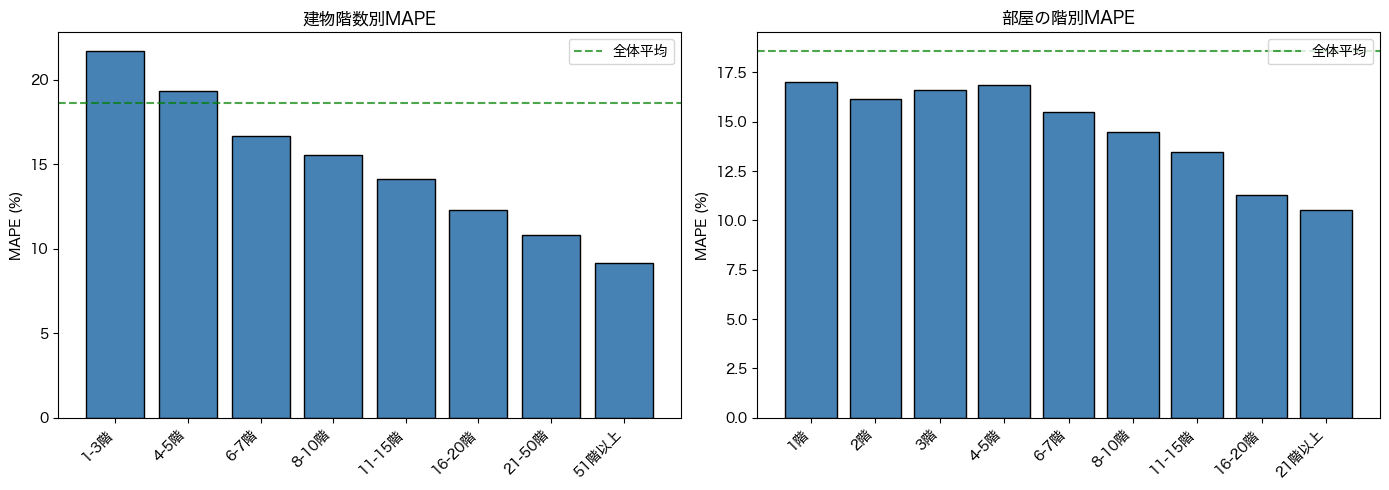

In [16]:
# 4.5 階数別MAPE
# 階数ビンを作成
analysis_full['floor_bin'] = pd.cut(
    analysis_full['floor_count'], 
    bins=[0, 3, 5, 7, 10, 15, 20, 50, 100],
    labels=['1-3階', '4-5階', '6-7階', '8-10階', '11-15階', '16-20階', '21-50階', '51階以上']
)

floor_stats = analyze_mape_by_category(
    analysis_full.dropna(subset=['floor_bin']), 
    'floor_bin', '建物階数'
)

# 4.6 部屋の階別MAPE  
analysis_full['room_floor_bin'] = pd.cut(
    analysis_full['room_floor'], 
    bins=[0, 1, 2, 3, 5, 7, 10, 15, 20, 100],
    labels=['1階', '2階', '3階', '4-5階', '6-7階', '8-10階', '11-15階', '16-20階', '21階以上']
)

room_floor_stats = analyze_mape_by_category(
    analysis_full.dropna(subset=['room_floor_bin']), 
    'room_floor_bin', '部屋の階'
)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 建物階数
ax1 = axes[0]
floor_order = ['1-3階', '4-5階', '6-7階', '8-10階', '11-15階', '16-20階', '21-50階', '51階以上']
floor_stats_sorted = floor_stats.reindex([f for f in floor_order if f in floor_stats.index])
ax1.bar(range(len(floor_stats_sorted)), floor_stats_sorted['MAPE'], color='steelblue', edgecolor='black')
ax1.set_xticks(range(len(floor_stats_sorted)))
ax1.set_xticklabels(floor_stats_sorted.index, rotation=45, ha='right')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('建物階数別MAPE')
ax1.axhline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均')
ax1.legend()

# 部屋の階
ax2 = axes[1]
room_order = ['1階', '2階', '3階', '4-5階', '6-7階', '8-10階', '11-15階', '16-20階', '21階以上']
room_stats_sorted = room_floor_stats.reindex([f for f in room_order if f in room_floor_stats.index])
ax2.bar(range(len(room_stats_sorted)), room_stats_sorted['MAPE'], color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(room_stats_sorted)))
ax2.set_xticklabels(room_stats_sorted.index, rotation=45, ha='right')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('部屋の階別MAPE')
ax2.axhline(18.6, color='green', linestyle='--', alpha=0.7, label='全体平均')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/mape_by_floor.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# 4.7 切り口別MAPEサマリー
print("=" * 80)
print("【切り口別MAPEサマリー】")
print("=" * 80)

summary_data = []

# 各切り口のワースト3を抽出
summaries = [
    ('都道府県', pref_stats, 'pref_name'),
    ('築年数', age_stats, 'age_bin'),
    ('専有面積', area_stats, 'area_bin'),
    ('建物構造', structure_stats, 'structure_name'),
    ('建物階数', floor_stats, 'floor_bin'),
    ('部屋の階', room_floor_stats, 'room_floor_bin'),
]

for name, stats, col in summaries:
    worst = stats.head(3)
    best = stats.tail(3)
    print(f"\n【{name}】")
    print(f"  ワースト3: {', '.join([f'{idx}({m:.1f}%)' for idx, m in zip(worst.index, worst['MAPE'])])}")
    print(f"  ベスト3:   {', '.join([f'{idx}({m:.1f}%)' for idx, m in zip(best.index[::-1], best['MAPE'][::-1])])}")
    
    # サマリーデータに追加
    for idx, row in worst.iterrows():
        summary_data.append({
            '切り口': name,
            'カテゴリ': idx,
            'MAPE': row['MAPE'],
            '件数': row['件数'],
            '種別': 'ワースト'
        })

# サマリーテーブル（MAPE順）
summary_df = pd.DataFrame(summary_data).sort_values('MAPE', ascending=False)
print("\n" + "=" * 80)
print("【全切り口 ワーストカテゴリ TOP 15（MAPE順）】")
print("=" * 80)
print(summary_df.head(15).to_string(index=False))

【切り口別MAPEサマリー】

【都道府県】
  ワースト3: 奈良(24.5%), 広島(24.1%), 長崎(23.6%)
  ベスト3:   東京(13.9%), 沖縄(14.7%), 大分(15.7%)

【築年数】
  ワースト3: 51年以上(24.1%), 46-50年(21.8%), 31-35年(20.6%)
  ベスト3:   6-10年(11.7%), 11-15年(12.6%), 16-20年(13.8%)

【専有面積】
  ワースト3: 150㎡~(25.2%), 100-150㎡(20.8%), 80-100㎡(18.4%)
  ベスト3:   20-30㎡(13.3%), 30-40㎡(15.5%), ~20㎡(17.0%)

【建物構造】
  ワースト3: その他(29.7%), RC造(24.8%), HPC造(22.6%)
  ベスト3:   木造(15.7%), 軽量鉄骨造(15.9%), ブロック造(17.2%)

【建物階数】
  ワースト3: 1-3階(21.7%), 4-5階(19.3%), 6-7階(16.7%)
  ベスト3:   51階以上(9.2%), 21-50階(10.8%), 16-20階(12.3%)

【部屋の階】
  ワースト3: 1階(17.0%), 4-5階(16.9%), 3階(16.6%)
  ベスト3:   21階以上(10.5%), 16-20階(11.3%), 11-15階(13.4%)

【全切り口 ワーストカテゴリ TOP 15（MAPE順）】
 切り口     カテゴリ  MAPE       件数   種別
建物構造      その他 29.71      5.0 ワースト
専有面積    150㎡~ 25.21  20365.0 ワースト
建物構造      RC造 24.83    101.0 ワースト
都道府県       奈良 24.51   3759.0 ワースト
 築年数    51年以上 24.14  25088.0 ワースト
都道府県       広島 24.07   4873.0 ワースト
都道府県       長崎 23.56    778.0 ワースト
建物構造     HPC造 22.56   2177.0 ワースト
 築年数   46-50年 21.7

In [18]:
# MAPE > 50% のサンプル
high_error = analysis_df[analysis_df['pct_error'] > 50].copy()
print(f"MAPE > 50% のサンプル: {len(high_error)}件 ({len(high_error)/len(analysis_df)*100:.1f}%)")

# MAPE > 100% のサンプル
very_high_error = analysis_df[analysis_df['pct_error'] > 100].copy()
print(f"MAPE > 100% のサンプル: {len(very_high_error)}件 ({len(very_high_error)/len(analysis_df)*100:.1f}%)")

# 高誤差サンプルの賃料分布
print("\n高誤差サンプル（MAPE > 50%）の実測値統計:")
print(f"  平均賃料: {high_error['actual'].mean():,.0f}円")
print(f"  中央値賃料: {high_error['actual'].median():,.0f}円")
print(f"  最小賃料: {high_error['actual'].min():,.0f}円")
print(f"  最大賃料: {high_error['actual'].max():,.0f}円")

MAPE > 50% のサンプル: 21878件 (6.0%)
MAPE > 100% のサンプル: 3811件 (1.0%)

高誤差サンプル（MAPE > 50%）の実測値統計:
  平均賃料: 12,548,281円
  中央値賃料: 9,000,000円
  最小賃料: 4,900,000円
  最大賃料: 188,000,000円


In [19]:
# 高誤差サンプルの価格帯分布
print("高誤差サンプル（MAPE > 50%）の価格帯分布:")
high_error_price_dist = high_error['actual_bin'].value_counts().sort_index()
for q, cnt in high_error_price_dist.items():
    total = (oof_df['actual_bin'] == q).sum()
    pct = cnt / total * 100 if total > 0 else 0
    print(f"  {q}: {cnt}件 ({pct:.1f}%)")

高誤差サンプル（MAPE > 50%）の価格帯分布:
  Q1: 11154件 (29.8%)
  Q2: 4681件 (12.1%)
  Q3: 1889件 (5.7%)
  Q4: 1283件 (3.5%)
  Q5: 920件 (2.5%)
  Q6: 502件 (1.4%)
  Q7: 424件 (1.0%)
  Q8: 262件 (0.8%)
  Q9: 327件 (0.9%)
  Q10: 436件 (1.2%)


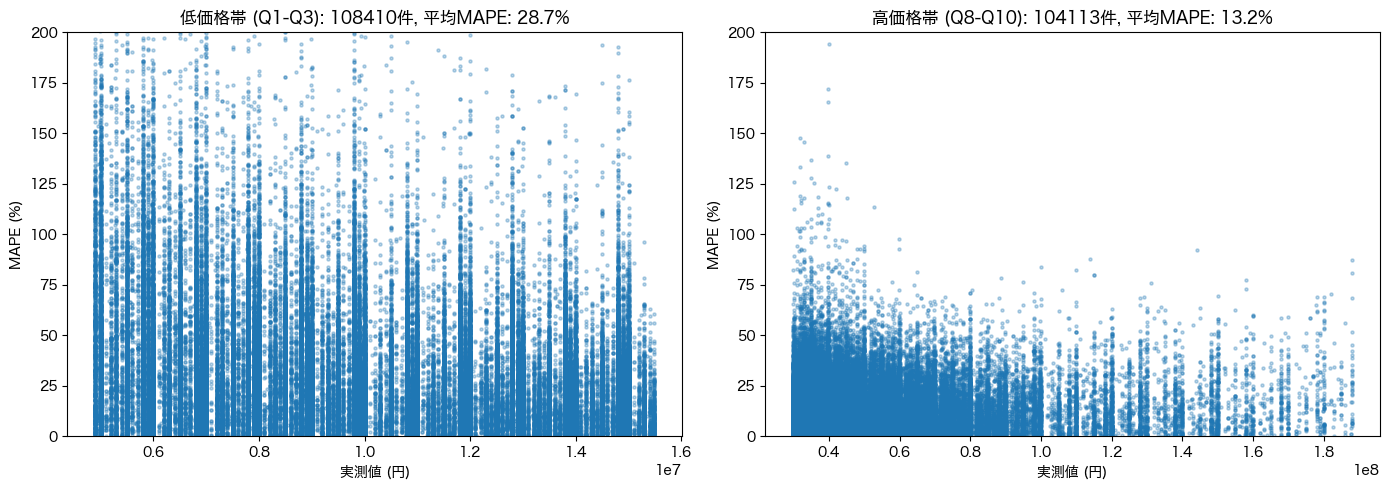

In [20]:
# 価格帯と誤差の関係（詳細）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 低価格帯（Q1-Q3）の分析
ax1 = axes[0]
low_price = analysis_df[analysis_df['actual'] < analysis_df['actual'].quantile(0.3)]
ax1.scatter(low_price['actual'], low_price['pct_error'], alpha=0.3, s=5)
ax1.set_xlabel('実測値 (円)')
ax1.set_ylabel('MAPE (%)')
ax1.set_title(f'低価格帯 (Q1-Q3): {len(low_price)}件, 平均MAPE: {low_price["pct_error"].mean():.1f}%')
ax1.set_ylim(0, 200)

# 高価格帯（Q8-Q10）の分析
ax2 = axes[1]
high_price = analysis_df[analysis_df['actual'] > analysis_df['actual'].quantile(0.7)]
ax2.scatter(high_price['actual'], high_price['pct_error'], alpha=0.3, s=5)
ax2.set_xlabel('実測値 (円)')
ax2.set_ylabel('MAPE (%)')
ax2.set_title(f'高価格帯 (Q8-Q10): {len(high_price)}件, 平均MAPE: {high_price["pct_error"].mean():.1f}%')
ax2.set_ylim(0, 200)

plt.tight_layout()
plt.savefig('../outputs/error_by_price_range.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# 予測バイアス分析（価格帯別の過小/過大評価傾向）
print("価格帯別の予測バイアス:")
for q in oof_df['actual_bin'].unique():
    subset = oof_df[oof_df['actual_bin'] == q]
    under = (subset['error'] < 0).sum()
    over = (subset['error'] > 0).sum()
    avg_err = subset['error'].mean()
    bias = "過小評価傾向" if avg_err < 0 else "過大評価傾向"
    print(f"  {q}: 平均誤差 {avg_err:+,.0f}円 ({bias}), 過小/過大 = {under}/{over}")

価格帯別の予測バイアス:
  Q3: 平均誤差 +1,149,918円 (過大評価傾向), 過小/過大 = 13305/19861
  Q6: 平均誤差 +104,844円 (過大評価傾向), 過小/過大 = 18669/17994
  Q4: 平均誤差 +930,371円 (過大評価傾向), 過小/過大 = 15891/20928
  Q5: 平均誤差 +740,443円 (過大評価傾向), 過小/過大 = 16535/20122
  Q1: 平均誤差 +2,404,455円 (過大評価傾向), 過小/過大 = 6981/30452
  Q2: 平均誤差 +1,821,824円 (過大評価傾向), 過小/過大 = 11683/26949
  Q8: 平均誤差 -765,240円 (過小評価傾向), 過小/過大 = 18141/13422
  Q10: 平均誤差 -5,160,339円 (過小評価傾向), 過小/過大 = 24297/11558
  Q9: 平均誤差 -1,675,618円 (過小評価傾向), 過小/過大 = 22988/13707
  Q7: 平均誤差 -153,427円 (過小評価傾向), 過小/過大 = 21608/18833


## 5. 過小評価 vs 過大評価の分析

In [22]:
# 過小評価（予測 < 実測）vs 過大評価（予測 > 実測）
under_pred = analysis_df[analysis_df['error'] < 0]
over_pred = analysis_df[analysis_df['error'] > 0]

print(f"過小評価: {len(under_pred)}件 ({len(under_pred)/len(analysis_df)*100:.1f}%)")
print(f"過大評価: {len(over_pred)}件 ({len(over_pred)/len(analysis_df)*100:.1f}%)")
print()
print(f"過小評価の平均誤差: {under_pred['error'].mean():,.0f}円")
print(f"過大評価の平均誤差: {over_pred['error'].mean():,.0f}円")
print()
print(f"過小評価の平均MAPE: {under_pred['pct_error'].mean():.2f}%")
print(f"過大評価の平均MAPE: {over_pred['pct_error'].mean():.2f}%")

過小評価: 170098件 (46.7%)
過大評価: 193826件 (53.3%)

過小評価の平均誤差: -4,342,823円
過大評価の平均誤差: 3,743,580円

過小評価の平均MAPE: 13.72%
過大評価の平均MAPE: 22.88%


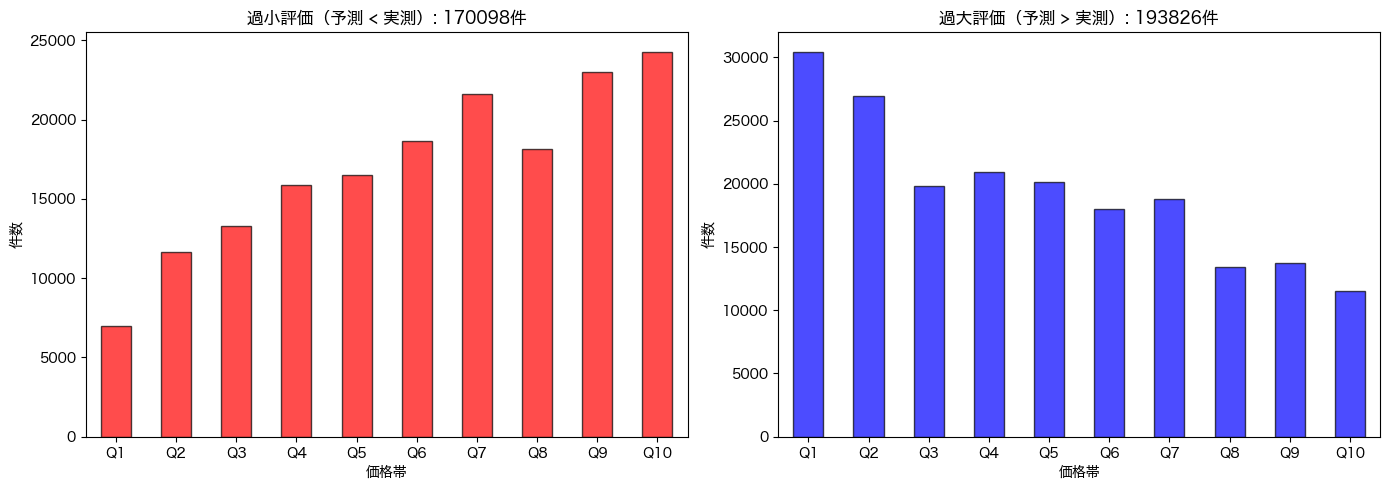

In [23]:
# 過小評価/過大評価の価格帯別分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 過小評価の分布
ax1 = axes[0]
under_bins = under_pred['actual_bin'].value_counts().sort_index()
under_bins.plot(kind='bar', ax=ax1, color='red', alpha=0.7, edgecolor='black')
ax1.set_xlabel('価格帯')
ax1.set_ylabel('件数')
ax1.set_title(f'過小評価（予測 < 実測）: {len(under_pred)}件')
ax1.tick_params(axis='x', rotation=0)

# 過大評価の分布
ax2 = axes[1]
over_bins = over_pred['actual_bin'].value_counts().sort_index()
over_bins.plot(kind='bar', ax=ax2, color='blue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('価格帯')
ax2.set_ylabel('件数')
ax2.set_title(f'過大評価（予測 > 実測）: {len(over_pred)}件')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../outputs/prediction_bias.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 改善の余地がある領域の特定

In [24]:
# セグメント別のMAPE
segments = []

# 価格帯別
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']:
    subset = oof_df[oof_df['actual_bin'] == q]
    segments.append({
        'セグメント': f'価格帯_{q}',
        '件数': len(subset),
        'MAPE': subset['pct_error'].mean(),
        '平均実測値': subset['actual'].mean()
    })

segments_df = pd.DataFrame(segments).sort_values('MAPE', ascending=False)
print("改善の余地があるセグメント（MAPE順）:")
segments_df.round(2)

改善の余地があるセグメント（MAPE順）:


,セグメント,件数,MAPE,平均実測値
0,価格帯_Q1,37433,40.89,7136339.72
1,価格帯_Q2,38632,25.02,11159781.35
2,価格帯_Q3,33166,18.90,14212118.58
3,価格帯_Q4,36819,17.22,16972843.74
4,価格帯_Q5,36657,15.77,20110138.66
5,価格帯_Q6,36663,14.32,23683911.22
9,価格帯_Q10,35855,14.00,67564796.69
6,価格帯_Q7,40441,13.22,27735486.74
8,価格帯_Q9,36695,12.83,39743420.13
7,価格帯_Q8,31563,12.73,32701138.40


---

## 7. 改善方針まとめ

<cell_type>markdown</cell_type>### 現状分析結果

| 項目 | 値 |
|------|----|
| CV MAPE | 18.60% (±0.09%) |
| 前回比改善 | 8.87pt (exp003: 27.47%) |
| 特徴量数 | 89個 |
| Best iteration | 10,000（early_stopping未到達）|

### エラー分析の主要発見

#### 1. 価格帯別の誤差傾向
| 価格帯 | MAPE | 高誤差(>50%)率 | バイアス |
|--------|------|----------------|----------|
| Q1 (低価格) | 40.89% | 29.8% | +240万円（過大評価）|
| Q2 | 25.02% | 12.1% | +182万円（過大評価）|
| Q3-Q6 | 14-19% | 1-6% | 過大評価傾向 |
| Q7-Q9 | 12-13% | 1%未満 | 過小評価傾向 |
| Q10 (高価格) | 14.00% | 1.2% | -516万円（過小評価）|

**重要な発見**: 
- 低価格帯(Q1)が最大のボトルネック（MAPE 40.89%）
- 高誤差サンプルの51%がQ1に集中
- 低価格帯は過大評価、高価格帯は過小評価の傾向

#### 2. 新規特徴量の効果
| 特徴量 | 順位 | 評価 |
|--------|------|------|
| building_age | 8位/89 | ⭐ 高効果 |
| building_age_bin | 16位/89 | ○ 効果あり |
| old_and_large_flag | 49位/89 | △ 限定的 |
| old_and_rural_flag | 65位/89 | △ 限定的 |
| old_building_flag | 88位/89 | × ほぼ無効 |

---

## 🎯 Next Actions（優先順位順）

### 即実行（exp005で試す）
1. **🔥 n_estimators増加**
   - 現状: 10,000イテレーションでearly_stopping未到達
   - 対策: n_estimators=30,000 に増加
   - 期待効果: 1-2pt改善

2. **🔥 対数変換（ターゲット）**
   - 現状: 低価格帯のMAPEが40%超
   - 対策: `y = log(money_room)` で学習、予測後に `exp()` で戻す
   - 期待効果: 低価格帯のMAPE大幅改善

### 次フェーズ（exp006以降）
3. **地域×築年数の交互作用TE**
   - `addr1_1 × building_age_bin` のTarget Encoding
   - 都市部と地方で築年数の影響が異なる

4. **価格帯別モデル**
   - Q1-Q3用モデルとQ4-Q10用モデルを分離
   - または価格帯をメタ特徴量として追加

5. **外れ値処理**
   - MAPE > 100%のサンプル（1%）の特徴を分析
   - 特殊物件の除外 or 特別処理

### 長期検討
6. **アンサンブル**: XGBoost, CatBoost追加
7. **Optunaチューニング**: ハイパーパラメータ最適化
8. **時系列CV**: 2019-2021年でtrain、2022年でvalidation

In [25]:
print("✅ エラー分析完了")
print("\n保存したファイル:")
print("  - error_distribution.png")
print("  - feature_importance_top20.png")
print("  - error_by_price_range.png")
print("  - error_by_building_age.png")
print("  - prediction_bias.png")

✅ エラー分析完了

保存したファイル:
  - error_distribution.png
  - feature_importance_top20.png
  - error_by_price_range.png
  - error_by_building_age.png
  - prediction_bias.png
